##Recurrent neural network


###Tarea: Detección bimodal


In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from numba import njit
import torch   # redes
import torch.nn.functional as F  # activation functions
from torch import optim  # optimizers.
from torch import nn  # neural network modules
from tqdm import tqdm  # For a nice progress bar!
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pasos =0.02
tfinal = 5.8
sigma = 0.01
Nens = 10000
tv = np.arange(0,tfinal,pasos)  #Vector de tiempo
Amplitudes = np.array([sigma,5*sigma,0.1,0.5])

Aud = np.zeros((len(tv),Nens))
Tac = np.zeros((len(tv),Nens))
marcas = np.zeros((3,len(tv),Nens))
go_cue = np.zeros((len(tv),Nens))
contexto = np.zeros((len(tv),Nens))
Vcontexto = np.zeros((3,len(tv),Nens))
Tiempos = np.zeros((3,Nens))
objetivos = np.zeros((1,Nens))
Estimulos = np.zeros((2,Nens))

for e in range(Nens):
  Aud[:,e] = 0 + np.sqrt(2)*sigma*np.random.normal(0,1,len(tv))
  Tac[:,e] = 0 + np.sqrt(2)*sigma*np.random.normal(0,1,len(tv))

  T1 = int(np.random.choice(np.array([1/3,2/3,1]))/0.02)
  T2 = int(np.random.choice(np.array([0.5,1,1.5,2]))/0.02)
  Tiempos[0,e] = T1
  Tiempos[1,e] = T2
  Tiempos[2,e] = (T1+10) + (T2+25) + 50 + 50
  go_cue[T1+10+T2+25+50-1:T1+10+T2+25+100,e] = 1

  variacionDeTarea = np.random.choice(np.array([0])) #,1,2
  contexto[:,e] = variacionDeTarea
  Vcontexto[variacionDeTarea,:,e] = 1

  #Variación 1
  if variacionDeTarea == 0: #
    pista = np.array([0,0])
    tipoDeEstimulo = np.random.choice(np.array([0,1,2]))
    if tipoDeEstimulo == 0:
      estimulo = np.array([0,0])
      marcas[0,T1+10+T2+25+50:T1+10+T2+25+100,e] = 1
      objetivos[0,e] = 0
    elif tipoDeEstimulo == 1:
      Amp = np.random.choice(Amplitudes)
      estimulo = np.array([Amp,0])
      marcas[1,T1+10+T2+25+50:T1+10+T2+25+100,e] = 1
      objetivos[0,e] = 1
    else:
      Amp = np.random.choice(Amplitudes)
      estimulo = np.array([0,Amp])
      marcas[2,T1+10+T2+25+50:T1+10+T2+25+100,e] = 1
      objetivos[0,e] = 2

  #Variación 2
  if variacionDeTarea == 1:
    tipoDePista = np.random.choice(np.array([0,1,2]))
    if  tipoDePista == 0:
      pista = np.array([0,0])
    elif tipoDePista == 1:
      pista = np.array([0.5,0])
    else:
      pista = np.array([0,0.5])

    tipoDeEstimulo = np.random.choice(np.array([0,1,2]))
    if tipoDeEstimulo == 0:
      estimulo = np.array([0,0])
      marcas[0,T1+10+T2+25+50:T1+10+T2+25+100,e] = 1
      objetivos[0,e] = 0
    elif tipoDeEstimulo == 1:
      Amp = np.random.choice(Amplitudes)
      estimulo = np.array([Amp,0])
      if pista[0] == 0.5:
        marcas[1,T1+10+T2+25+50:T1+10+T2+25+100,e] = 1
        objetivos[0,e] = 1
      else:
        marcas[0,T1+10+T2+25+50:T1+10+T2+25+100,e] = 1
        objetivos[0,e] = 0
    else:
      Amp = np.random.choice(Amplitudes)
      estimulo = np.array([0,Amp])
      if pista[1] == 0.5:
        marcas[2,T1+10+T2+25+50:T1+10+T2+25+100,e] = 1
        objetivos[0,e] = 2
      else:
        marcas[0,T1+10+T2+25+50:T1+10+T2+25+100,e] = 1
        objetivos[0,e] = 0

  #Variación 3
  if variacionDeTarea == 2:
    tipoDePista = np.random.choice(np.array([0,1,2]))
    if  tipoDePista == 0:
      pista = np.array([0,0])
    elif tipoDePista == 1:
      pista = np.array([0.5,0])
    else:
      pista = np.array([0,0.5])

    tipoDeEstimulo = np.random.choice(np.array([0,1,2]))
    if tipoDeEstimulo == 0:
      estimulo = np.array([0,0])
      marcas[0,T1+10+T2+25+50:T1+10+T2+25+100,e] = 1
      objetivos[0,e] = 0
    elif tipoDeEstimulo == 1:
      Amp = np.random.choice(Amplitudes)
      Dis = np.random.choice(Amplitudes)
      estimulo = np.array([Amp,Dis])
      if pista[0] == 0.5:
        marcas[1,T1+10+T2+25+50:T1+10+T2+25+100,e] = 1
        objetivos[0,e] = 1
      else:
        marcas[0,T1+10+T2+25+50:T1+10+T2+25+100,e] = 1
        objetivos[0,e] = 0
    else:
      Amp = np.random.choice(Amplitudes)
      Dis = np.random.choice(Amplitudes)
      estimulo = np.array([Dis,Amp])
      if pista[1] == 0.5:
        marcas[2,T1+10+T2+25+50:T1+10+T2+25+100,e] = 1
        objetivos[0,e] = 2
      else:
        marcas[0,T1+10+T2+25+50:T1+10+T2+25+100,e] = 1
        objetivos[0,e] = 0

  Estimulos[:,e] = estimulo
  Aud[T1:T1+10,e] += pista[0]
  Tac[T1:T1+10,e] += pista[1]
  Aud[T1+10+T2:T1+10+T2+25,e] += estimulo[0]
  Tac[T1+10+T2:T1+10+T2+25,e] += estimulo[1]


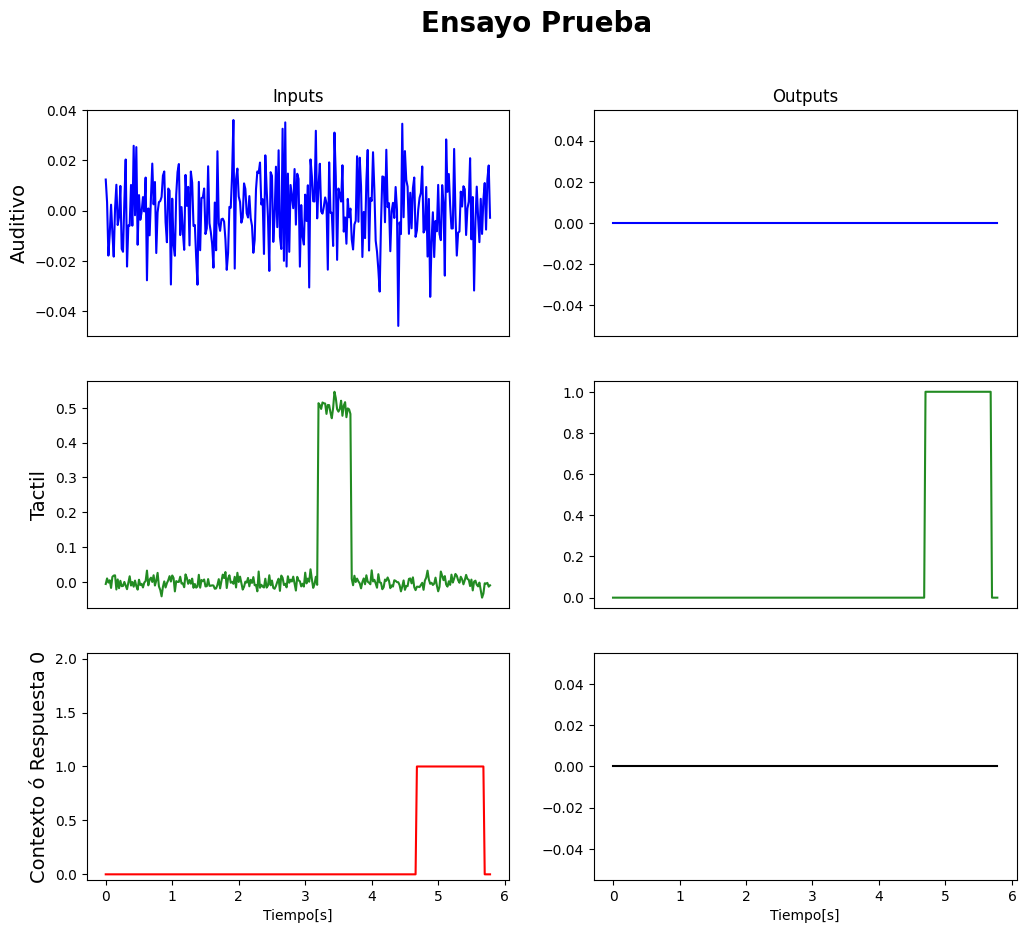

Objetivo = 2


In [3]:
if e > 100:
  e = 1
else:
  e += 1
#plt.style.use('seaborn-darkgrid')
plt.figure(figsize=[12,10])

plt.subplot(321)
plt.plot(tv,Aud[:,e],color="blue")
plt.title("Inputs")
plt.ylabel("Auditivo",fontsize=14)
plt.tick_params(labelbottom = False, bottom = False)

plt.subplot(323)
plt.plot(tv,Tac[:,e],color="forestgreen")
plt.ylabel("Tactil",fontsize=14)
plt.tick_params(labelbottom = False, bottom = False)

plt.subplot(325)
plt.plot(tv,go_cue[:,e],color="red")
plt.xlabel("Tiempo[s]")
plt.ylim([-0.05,2.05])
plt.ylabel("Contexto ó Respuesta 0",fontsize=14)

plt.subplot(322)
plt.plot(tv,marcas[1,:,e],color="blue")
plt.title("Outputs")
plt.tick_params(labelbottom = False, bottom = False)

plt.subplot(324)
plt.plot(tv,marcas[2,:,e],color="forestgreen")
plt.tick_params(labelbottom = False, bottom = False)

plt.subplot(326)
plt.plot(tv,marcas[0,:,e],color="black")
plt.xlabel("Tiempo[s]")

plt.suptitle("Ensayo Prueba",weight="bold",fontsize=20)
plt.show()

print("Objetivo = %d" % (objetivos[0,e]))

In [2]:
# Hyperparameters
input_size = 3
sequence_length = len(tv)
batch_size = 64
num_classes = 3
hidden_size = 256
learning_rate = 0.0005
num_epochs = 1

class RNN_custom(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_custom, self).__init__()

        self.hidden_size = hidden_size
        self.os= output_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

        self.i2h.weight.data.fill_(0)
        K = torch.zeros((hidden_size,hidden_size+input_size))
        K[:,0:input_size] = -np.sqrt(2.)*torch.rand(hidden_size,input_size)+1/np.sqrt(2.)                        #input
        K[:,input_size:] = torch.normal(0.,0.3/np.sqrt(hidden_size),size=(hidden_size,hidden_size)) #h no diag
        for i in range(hidden_size):                                    #h diag
          K[i,i+input_size] = 0.99
        self.i2h.weight.data = self.i2h.weight.data + K
        self.h2o.weight.data.normal_(0.,0.4/np.sqrt(hidden_size))          #output
        self.i2h.bias.data.fill_(0.)
        self.h2o.bias.data.fill_(0.)

    def forward(self, input_tensor,fines,b):
        h0 = torch.zeros(1, self.hidden_size).to(device)
        hidden_all = torch.zeros((1,input_tensor.size(1),self.hidden_size))
        hidden = h0
        output = torch.zeros((1,int(fines[0,b]),self.os)) #input_tensor.size(1)

        for i in range(int(fines[0,b])): #input_tensor.size(1)
          combined = torch.cat((input_tensor[b,i,:].view(-1, 1), hidden[0,:].view(-1, 1)), 0) #.view(-1, 1)
          hidden = self.i2h(combined.reshape(-1,1).t())+(np.sqrt(2)*0.05)*torch.randn_like(hidden) #hidden.size()
          hidden = F.softplus(hidden)
          hidden_all[0,i,:] = hidden
          output[0,i,:] = torch.clamp(self.h2o(hidden),min=-1000,max=1000) #.view(-1, 2)torch.sigmoid, F.softplus()

        return output, hidden_all

model = RNN_custom(input_size, hidden_size, num_classes).to(device)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/
model.load_state_dict(torch.load('Modelo BDT T_var2.txt'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


<ipython-input-4-6efb9e4de180>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Modelo BDT T_var2.txt'))


<All keys matched successfully>

## Entrenamiento


In [29]:
new = False
if new == True:
  model = RNN_custom(input_size, hidden_size, num_classes).to(device)
  criterion = nn.MSELoss(reduction="sum")
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  perdida = []
  desempeño1 = []
  desempeño2 = []


def check_accuracy(model):
    num_correct1 = 0
    num_correct2 = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():
        for i in range(8):

          inputs, labels, inicio, fin, obj = getRandomTrails()

          data = torch.from_numpy(inputs)
          data = data.to(device=device).type(torch.FloatTensor) #.squeeze(1)
          targets = torch.from_numpy(labels) #.type(torch.LongTensor)
          targets = targets.to(device=device) #.reshape(batch_size)
          targets = targets.float()

          scores = torch.zeros(targets.shape)
          # forward
          for b in range(batch_size):
            scores1, _ = model(data,fin,b)
            scores1[0,:int(inicio[0,b]-1),:] *= 0
            scores[b,:int(fin[0,b]),:] = scores1

          for b in range(batch_size):
            num_samples += 1
            ti = int(fin[0,b])
            if torch.max(scores[b,:ti-50-1,:]) < 0.25 and ((torch.max(scores[b,ti-50:ti,0]) > 0.5 and torch.max(scores[b,ti-50:ti,1]) < 0.5 and torch.max(scores[b,ti-50:ti,2]) < 0.5) or
                                                        (torch.max(scores[b,ti-50:ti,0]) < 0.5 and torch.max(scores[b,ti-50:ti,1]) > 0.5 and torch.max(scores[b,ti-50:ti,2]) < 0.5) or
                                                        (torch.max(scores[b,ti-50:ti,0]) < 0.5 and torch.max(scores[b,ti-50:ti,1]) < 0.5 and torch.max(scores[b,ti-50:ti,2]) > 0.5)):
              num_correct1 += 1
              if torch.max(scores[b,ti-50:ti,int(obj[0,b])]) > 0.5:
                num_correct2 += 1

    model.train()
    try:
      return num_correct1/num_samples*100, num_correct2/num_correct1*100
    except:
      return num_correct1/num_samples*100, 0

@njit
def getRandomTrails():
  inputs = np.zeros((batch_size,len(tv),input_size)) #3
  labels = np.zeros((batch_size, len(tv),num_classes))
  inicio = np.zeros((1,batch_size))
  fin = np.zeros((1,batch_size))
  obj = np.zeros((1,batch_size))
  for b in range(batch_size):
    r = np.random.randint(10000)
    inputs[b,:,0] = Aud[:,r]
    inputs[b,:,1] = Tac[:,r]                 #inputs, labels = dataset()
    inputs[b,:,2] = go_cue[:,r]
    labels[b,:,0] = marcas[0,:,r]
    labels[b,:,1] = marcas[1,:,r]
    labels[b,:,2] = marcas[2,:,r]
    inicio[0,b] = int(Tiempos[0,r])
    fin[0,b] = int(Tiempos[2,r])
    obj[0,b] = objetivos[0,r]

  return inputs, labels, inicio, fin, obj

# Train Network
for i in tqdm(range(1,200*5+1)):
    if i%20 == 0:
      perdida.append(loss.detach().numpy())
    if i%20 == 0:
      d1, d2 = check_accuracy(model)
      desempeño1.append(d1)
      desempeño2.append(d2)
      print("  loss: ", int(loss), "d1: ", d1, "d2: ", d2)
      #torch.save(model.state_dict(), "Modelo BDT T_var.txt")
      if d1>80 and d2<80: #and loss<6
        break

    inputs, labels, inicio, fin, _ = getRandomTrails()

    data = torch.from_numpy(inputs)
    data = data.to(device=device).type(torch.FloatTensor) #.squeeze(1)
    targets = torch.from_numpy(labels) #.type(torch.LongTensor)
    targets = targets.to(device=device) #.reshape(batch_size)
    targets = targets.float()

    # forward
    loss = 0
    for b in range(batch_size):
      scores, _ = model(data,fin,b)
      scores[0,:int(inicio[0,b]-1),:] *= 0
      loss += criterion(scores[0,:,:], targets[b,:int(fin[0,b]),:])

    # backward
    optimizer.zero_grad()
    loss.backward()

    # gradient descent update step/adam step
    optimizer.step()

plt.figure(figsize=(7,6))
plt.subplot(311)
plt.plot(desempeño1,color="forestgreen")
axes = plt.gca()
xi, xs = axes.get_xlim()
plt.hlines(95,xi,xs,linestyles="dashed")
plt.title("Producción de intervalo", weight="bold")
plt.ylabel("% producido")
plt.ylim([0,101])
plt.subplot(312)
plt.plot(desempeño2,color="blue")
plt.hlines(98,xi,xs,linestyles="dashed")
plt.ylim([0,101])
plt.ylabel("% correcto")
plt.subplot(313)
plt.plot(perdida[:],color="orangered")
plt.ylabel("Loss")
plt.xlabel("n. batches")
plt.show()

  2%|▏         | 19/1000 [03:52<3:16:30, 12.02s/it]

  loss:  400 d1:  94.3359375 d2:  90.47619047619048


  4%|▍         | 39/1000 [08:18<3:09:31, 11.83s/it]

  loss:  702 d1:  92.7734375 d2:  88.8421052631579


  6%|▌         | 59/1000 [12:45<3:07:57, 11.99s/it]

  loss:  243 d1:  93.75 d2:  89.16666666666667


  6%|▌         | 59/1000 [13:25<3:34:08, 13.65s/it]


KeyboardInterrupt: 

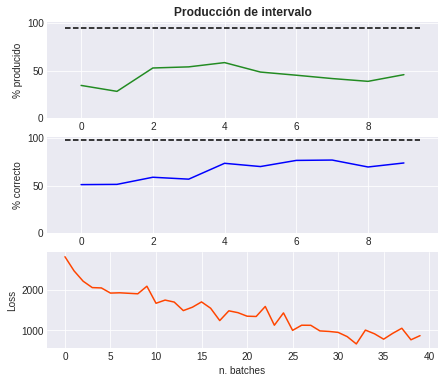

In [ ]:
plt.figure(figsize=(7,6))
plt.subplot(311)
plt.plot(desempeño1,color="forestgreen")
axes = plt.gca()
xi, xs = axes.get_xlim()
plt.hlines(95,xi,xs,linestyles="dashed")
plt.title("Producción de intervalo", weight="bold")
plt.ylabel("% producido")
plt.ylim([0,101])
plt.subplot(312)
plt.plot(desempeño2,color="blue")
plt.hlines(98,xi,xs,linestyles="dashed")
plt.ylim([0,101])
plt.ylabel("% correcto")
plt.subplot(313)
plt.plot(perdida[:],color="orangered")
plt.ylabel("Loss")
plt.xlabel("n. batches")
plt.show()

In [8]:
@njit
def getRandomTrailsAndInfo():
  inputs = np.zeros((batch_size,len(tv),input_size)) #3
  labels = np.zeros((batch_size, len(tv),num_classes))
  inicio = np.zeros((1,batch_size))
  T2s = np.zeros((1,batch_size))
  fin = np.zeros((1,batch_size))
  obj = np.zeros((1,batch_size))
  estimulo = np.zeros((2,batch_size))
  for b in range(batch_size):
    r = np.random.randint(10000)
    inputs[b,:,0] = Aud[:,r]
    inputs[b,:,1] = Tac[:,r]                 #inputs, labels = dataset()
    inputs[b,:,2] = go_cue[:,r]
    labels[b,:,0] = marcas[0,:,r]
    labels[b,:,1] = marcas[1,:,r]
    labels[b,:,2] = marcas[2,:,r]
    inicio[0,b] = int(Tiempos[0,r])
    T2s[0,b] = int(Tiempos[1,r])
    fin[0,b] = int(Tiempos[2,r])
    obj[0,b] = objetivos[0,r]
    estimulo[:,b] = Estimulos[:,r]

  return inputs, labels, inicio, fin, obj, estimulo, T2s

inputs, labels, inicio, fin, obj, estimulo, T2s = getRandomTrailsAndInfo()
data = torch.from_numpy(inputs)
data = data.to(device=device).type(torch.FloatTensor) #.squeeze(1)
targets = torch.from_numpy(labels) #.type(torch.LongTensor)
targets = targets.to(device=device) #.reshape(batch_size)
targets = targets.float()

with torch.no_grad():
  scores = torch.zeros(targets.shape)
  hidden = torch.zeros(batch_size,len(tv),hidden_size)
  for b in range(batch_size):
    scores1, hidden1 = model(data,fin,b)
    hidden[b,:,:] = hidden1
    scores1[0,:int(inicio[0,b]-1),:] *= 0
    scores[b,:int(fin[0,b]),:] = scores1

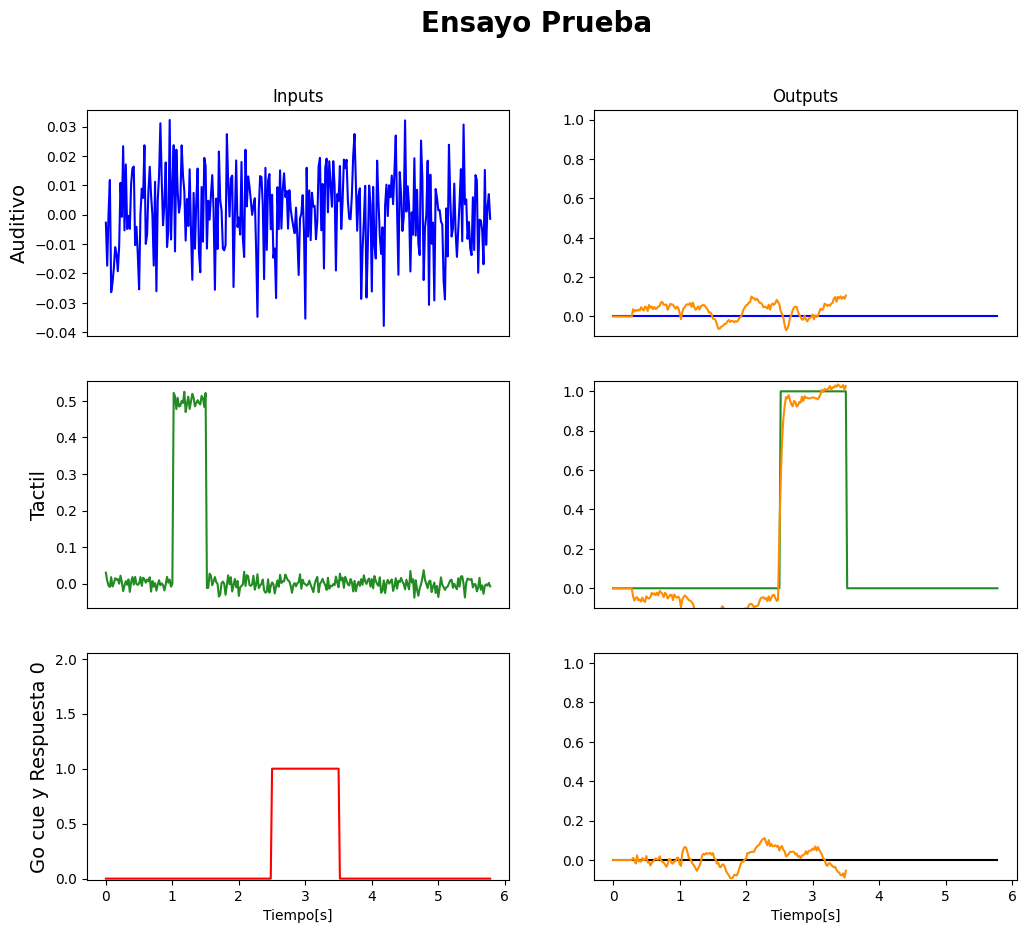

Amp auditivo = 0.000000, Amp tactil = 0.500000


In [20]:
if e > 63:
  e = 0
else:
  e += 1

prueba = scores[e,:int(fin[0,e]),:].detach().numpy()
#plt.style.use('seaborn-darkgrid')
plt.figure(figsize=[12,10])

plt.subplot(321)
plt.plot(tv,inputs[e,:,0],color="blue")
plt.title("Inputs")
plt.ylabel("Auditivo",fontsize=14)
plt.tick_params(labelbottom = False, bottom = False)

plt.subplot(323)
plt.plot(tv,inputs[e,:,1],color="forestgreen")
plt.ylabel("Tactil",fontsize=14)
plt.tick_params(labelbottom = False, bottom = False)

plt.subplot(325)
plt.plot(tv,inputs[e,:,2],color="red")
plt.xlabel("Tiempo[s]")
plt.ylim([-0.01,2.05])
plt.ylabel("Go cue y Respuesta 0",fontsize=14)

plt.subplot(322)
plt.plot(tv,labels[e,:,1],color="blue")
plt.plot(tv[:int(fin[0,e])],prueba[:,1], color="darkorange")
plt.ylim([-0.1,1.05])
plt.title("Outputs")
plt.tick_params(labelbottom = False, bottom = False)

plt.subplot(324)
plt.plot(tv,labels[e,:,2],color="forestgreen")
plt.ylim([-0.1,1.05])
plt.plot(tv[:int(fin[0,e])],prueba[:,2], color="darkorange")
plt.tick_params(labelbottom = False, bottom = False)

plt.subplot(326)
plt.plot(tv,labels[e,:,0],color="black")
plt.plot(tv[:int(fin[0,e])],prueba[:,0], color="darkorange")
plt.ylim([-0.1,1.05])
plt.xlabel("Tiempo[s]")

plt.suptitle("Ensayo Prueba",weight="bold",fontsize=20)
plt.show()

print("Amp auditivo = %f, Amp tactil = %f" % (estimulo[0,e],estimulo[1,e]))

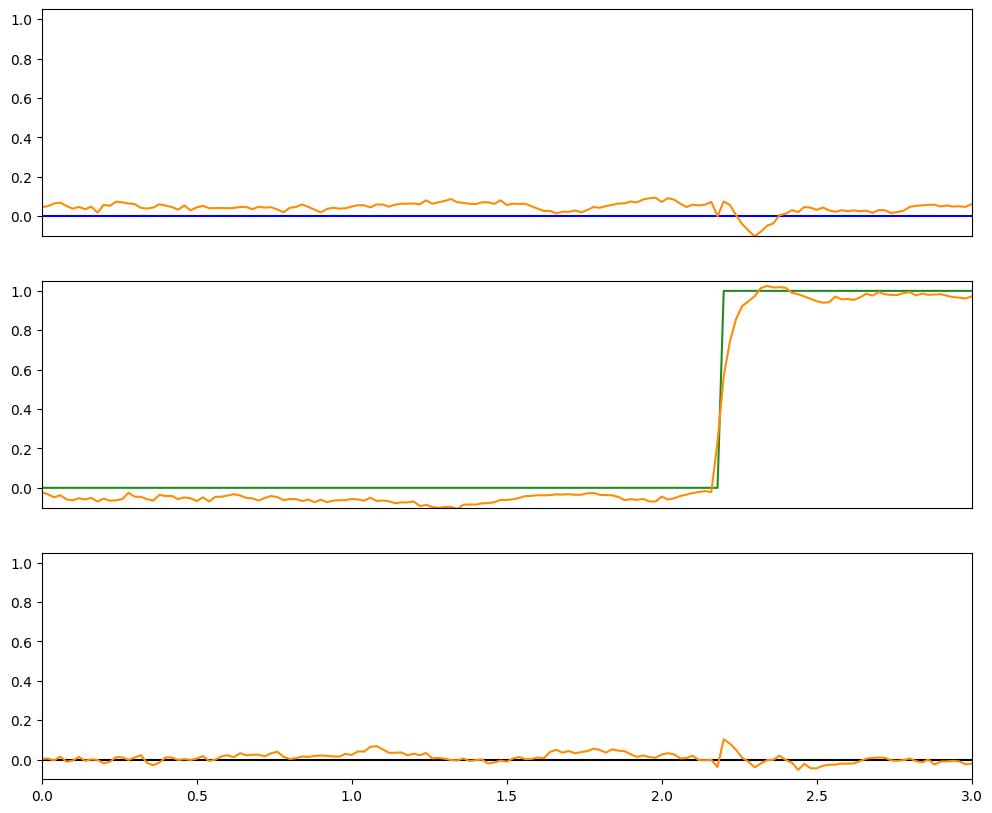

In [ ]:
prueba = scores[e,int(inicio[0,e]):int(fin[0,e]),:].detach().numpy()
plt.style.use('default')
plt.figure(figsize=[12,10])

plt.subplot(311)
plt.plot(tv - tv[int(inicio[0,e])],labels[e,:,1],color="blue")
plt.plot(tv[int(inicio[0,e]):int(fin[0,e])] - tv[int(inicio[0,e])],prueba[:,1], color="darkorange")
plt.ylim([-0.1,1.05])
plt.xlim([0,3])
plt.tick_params(labelbottom = False, bottom = False)

plt.subplot(312)
plt.plot(tv - tv[int(inicio[0,e])],labels[e,:,2],color="forestgreen")
plt.ylim([-0.1,1.05])
plt.xlim([0,3])
plt.plot(tv[int(inicio[0,e]):int(fin[0,e])] - tv[int(inicio[0,e])],prueba[:,2], color="darkorange")
plt.tick_params(labelbottom = False, bottom = False)

plt.subplot(313)
plt.plot(tv - tv[int(inicio[0,e])],labels[e,:,0],color="black")
plt.plot(tv[int(inicio[0,e]):int(fin[0,e])] - tv[int(inicio[0,e])],prueba[:,0], color="darkorange")
plt.ylim([-0.1,1.05])
plt.xlim([0,3])

plt.savefig("BDT_output.svg")
#plt.show()


## Psicometría

In [11]:
#mean in time
scores_mean = np.zeros((batch_size,num_classes))
for b in range(batch_size):
  scores_mean[b,:] = np.mean(scores[b, int(fin[0,b])-50:int(fin[0,b]), :].detach().numpy(), axis=0)

#normalize
scores_mean[scores_mean < 0.] = 0.
scores_mean[scores_mean > 1.] = 1.

#mean class
mean_amp = np.zeros((2,5))
mean_amp[0,0] = np.mean(scores_mean[np.all([estimulo[0,:] == 0., estimulo[1,:] == 0.], axis=0),1])
mean_amp[1,0] = np.mean(scores_mean[np.all([estimulo[0,:] == 0., estimulo[1,:] == 0.], axis=0),2])
for a,amp in enumerate(Amplitudes):
  mean_amp[0,a+1] = np.mean(scores_mean[estimulo[0,:] == amp,1])
  mean_amp[1,a+1] = np.mean(scores_mean[estimulo[1,:] == amp,2])

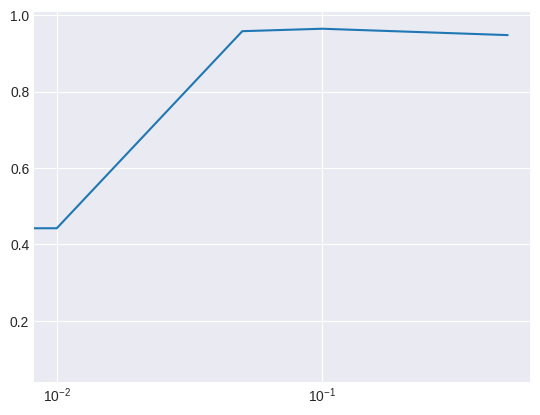

In [ ]:

plt.plot(np.append([0],Amplitudes),mean_amp[1,:])
#plt.plot(np.append([0],Amplitudes),mean_amp[2,:])
plt.xscale('log')
plt.show()

With more values

In [32]:
Amps2 = np.arange(0,0.06,0.003)
T1 = 30 #mean values
T2 = 62
lent = (T1+10) + (T2+25) + 50 + 50
c = 0 #Aud 0 Tac 1
fin = np.ones((1,len(Amps2)))*lent
inputs = np.zeros((len(Amps2),lent,num_classes))
for b,amp in enumerate(Amps2):
  inputs[b,T1+10+T2:T1+10+T2+25,c] = amp
  inputs[b,T1+10+T2+25+50:T1+10+T2+25+100,2] = 1

pn = 100
mean_amp = np.zeros((len(Amps2),num_classes,pn))
for p in range(pn):
  scores = torch.zeros((len(Amps2),lent,num_classes))
  scores_mean = np.zeros((len(Amps2),num_classes))
  with torch.no_grad():
    data = torch.from_numpy(inputs)
    data = data.to(device=device).type(torch.FloatTensor)
    for b,amp in enumerate(Amps2):
      scores1, _ = model(data,fin,b)
      scores[b,:,:] = scores1
      scores_mean[b,:] = np.mean(scores[b, lent-50:lent-1, :].detach().numpy(), axis=0)
  #normalize
  scores_mean[scores_mean < 0.] = 0.
  scores_mean[scores_mean > 1.] = 1.
  mean_amp[:,:,p] = scores_mean


In [31]:
mean_amp2 = np.copy(mean_amp)

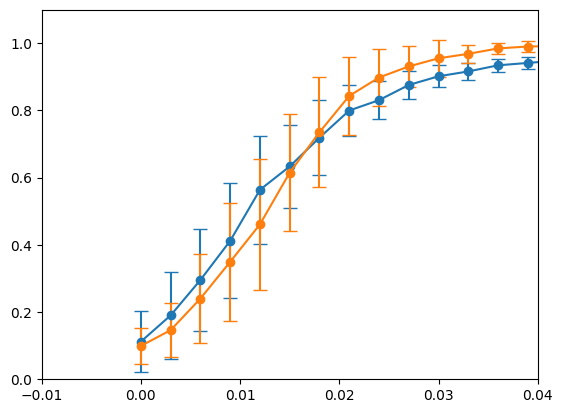

In [33]:
plt.style.use('default')
plt.errorbar(Amps2,np.mean(mean_amp[:,1,:],axis=1),1*np.std(mean_amp[:,1,:],axis=1), marker='o',capsize=5)
plt.errorbar(Amps2,np.mean(mean_amp2[:,2,:],axis=1),1*np.std(mean_amp2[:,2,:],axis=1), marker='o',capsize=5)

#plt.xscale('log')
plt.xlim([-0.01,0.04])
plt.ylim([0,1.1])

plt.savefig("BDT_psico_93.svg")
plt.show()

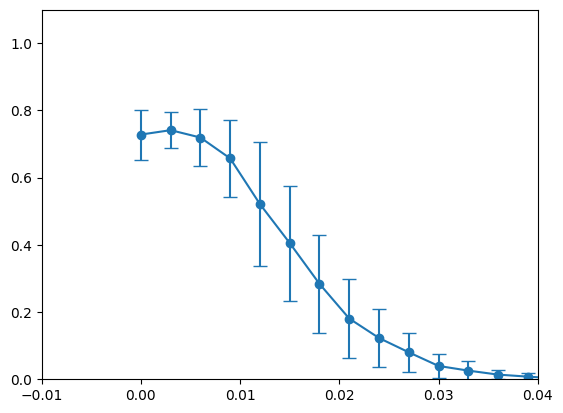

In [24]:
plt.style.use('default')
plt.errorbar(Amps2,np.mean(mean_amp[:,0,:],axis=1),1*np.std(mean_amp[:,0,:],axis=1), marker='o',capsize=5)
#plt.xscale('log')
plt.xlim([-0.01,0.04])
plt.ylim([0,1.1])

#plt.savefig("BDT_psico2.svg")
plt.show()

In [ ]:
mean_amp[:,1,:].shape

(12, 100)

Text(0, 0.5, '%')

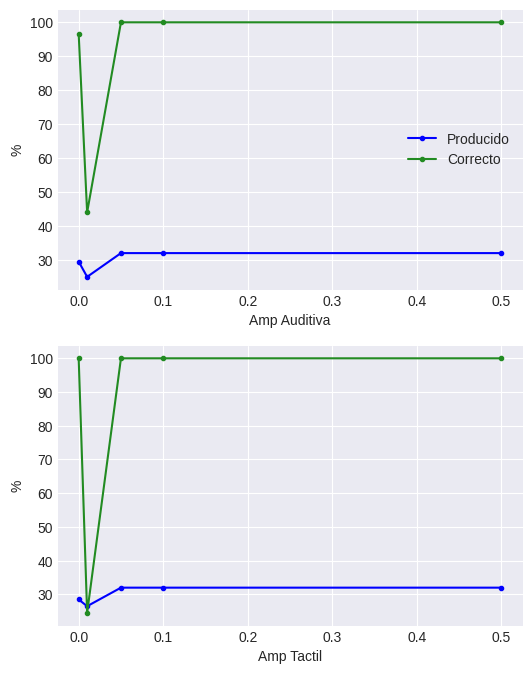

In [ ]:
plt.figure(figsize=(6,8))
plt.subplot(211)
plt.plot(Amplitudesy0, Psicomat[0,0,:],color="blue",label = "Producido", marker=".")
plt.plot(Amplitudesy0, Psicomat[0,1,:],color="forestgreen",label = "Correcto", marker=".")
plt.legend()
plt.xlabel("Amp Auditiva")
plt.ylabel("%")
plt.subplot(212)
plt.plot(Amplitudesy0, Psicomat[1,0,:],color="blue",marker=".")
plt.plot(Amplitudesy0, Psicomat[1,1,:],color="forestgreen", marker=".")
plt.xlabel("Amp Tactil")
plt.ylabel("%")

## Pesos

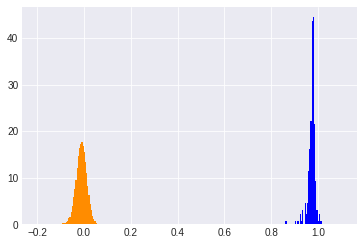

In [ ]:
pesos = model.i2h.weight[:,input_size:].detach().numpy()
bin = np.linspace(-0.2,1.1,256)
plt.hist(pesos.flatten(),bins=bin,color="darkorange",density=True)
plt.hist(np.diag(pesos),bins=bin,color="blue",density=True)
plt.show()

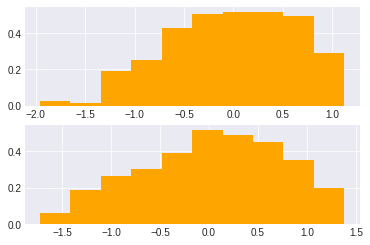

In [ ]:
pesos = model.i2h.weight[:,:input_size].detach().numpy()
plt.subplot(211)
plt.hist(pesos[:,0].flatten(),color="orange",density=True)
plt.subplot(212)
plt.hist(pesos[:,1].flatten(),color="orange",density=True)
plt.show()

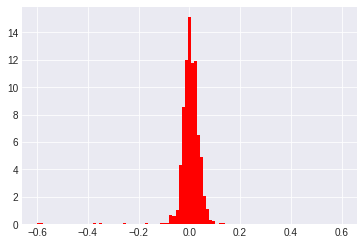

In [ ]:
pesos = model.h2o.weight.detach().numpy()
bin = np.linspace(-0.6,0.6,100)
plt.hist(pesos.flatten(),bins=bin,color="red",density=True)
plt.show()

## Actividad

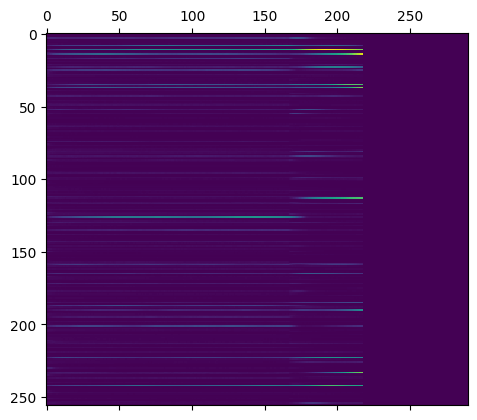

In [ ]:
plt.style.use('default')
oculton = hidden.detach().numpy()
plt.matshow(oculton[5,:,:].transpose())
plt.show()

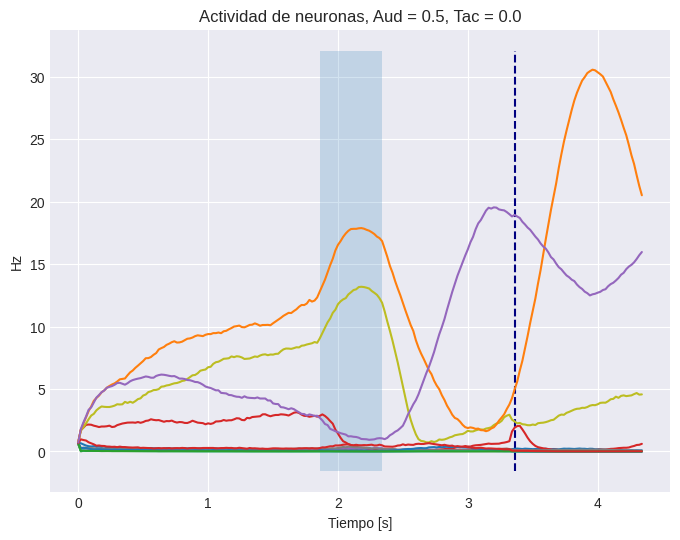

In [ ]:
plt.style.use('seaborn-darkgrid')
n = 2
plt.figure(figsize=(8,6))


for neu in range(15):
  plt.plot(tv[:int(fin[0,n])],oculton[n,:int(fin[0,n]),neu])
axes = plt.gca()
yi, ys = axes.get_ylim()

plt.fill_between(tv[int(inicio[0,n]+10+T2s[0,n]):int(inicio[0,n]+10+T2s[0,n]+25)], yi, ys, alpha=0.2)
plt.vlines(tv[int(fin[0,n])-50], yi, ys, colors = "navy", linestyles="dashed")
plt.title("Actividad de neuronas, Aud = " + str(estimulo[0,n]) + ", Tac = "+str(estimulo[1,n]))
plt.ylabel("Hz")
plt.xlabel("Tiempo [s]")
plt.show()

### Crear archivos txt

In [5]:
with torch.no_grad():
  inputs = np.zeros((400,len(tv),input_size))
  labels = np.zeros((400, len(tv),num_classes))
  Ts = np.zeros((400,5))
  inicio = np.zeros((1,400))
  fin = np.zeros((1,400))
  for b in range(400):
      r = b #np.random.randint(10000)
      inputs[b,:,0] = Aud[:,r]
      inputs[b,:,1] = Tac[:,r]                 #inputs, labels = dataset()
      inputs[b,:,2] = go_cue[:,r]
      labels[b,:,0] = marcas[0,:,r]
      labels[b,:,1] = marcas[1,:,r]
      labels[b,:,2] = marcas[2,:,r]
      Ts[b,0:3] = Tiempos[:,r]
      Ts[b,3:5] = Estimulos[:,r]
      inicio[0,b] = int(Tiempos[0,r])
      fin[0,b] = int(Tiempos[2,r])
  # Get data to cuda if possible
  data = torch.from_numpy(inputs)
  data = data.to(device=device).type(torch.FloatTensor) #.squeeze(1)
  targets = torch.from_numpy(labels) #.type(torch.LongTensor)
  targets = targets.to(device=device) #.reshape(batch_size)
  targets = targets.float()

  scores = torch.zeros(targets.shape)
  hiddens = torch.zeros(400,len(tv),hidden_size)
  for b in range(400):
    scores1, hidden1 = model(data,fin,b)
    hiddens[b,:,:] = hidden1
    scores1[0,:int(inicio[0,b]-1),0] *= 0
    scores[b,:int(fin[0,b]),:] = scores1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


Salvar estados ocultos

In [8]:
Hs = hiddens.detach().numpy()
# e , t, neu
# neu, e, t
Hs = Hs.transpose(2,0,1).reshape(-1,len(tv))
np.savetxt("BD_neu.txt",Hs.astype('float32'))

Salvar pesos

In [ ]:
pesos = model.i2h.weight[:,3:].detach().numpy()
bia = model.i2h.bias.detach().numpy()
pesos2 = model.i2h.weight[:,1].detach().numpy()


W = pesos
np.savetxt("BD_w.txt",W)
W.shape

(256, 256)

Salvar outs

In [ ]:
outs = model.h2o.weight.detach().numpy()
#outs.shape
np.dot(outs[0,:],outs[1,:])/(np.linalg.norm(outs[0,:])*np.linalg.norm(outs[1,:]))
np.savetxt("BD_out.txt",outs)

In [ ]:
print(np.linalg.norm(outs[0,:]), np.linalg.norm(outs[1,:]))

2.9148095 2.3054008


In [ ]:
model.h2o.bias.detach().numpy()

array([ 0.10923583, -0.02991437], dtype=float32)

Salvar info

In [6]:
np.savetxt("BD_info_T4.txt",Ts)

### Salvar modelo

In [34]:
torch.save(model.state_dict(), "Modelo BDT T_var2.txt")